# Task 1: Data Understanding (Exploratory Data Analysis)

*Objective:* Load the dataset, examine its structure, identify data quality issues (missing values, duplicates), and explore feature distributions and relationships.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from pathlib import Path
import os
import re

## 0. Configuration & Setup

In [2]:
# Define Project Paths (assuming notebook is in /notebooks)
# We move up one level to get to the project root
PROJECT_ROOT = Path(os.getcwd()).parent if os.getcwd().endswith('notebooks') else Path(os.getcwd())
DATA_RAW = PROJECT_ROOT / "data" / "raw" / "crash-data-aa.xlsx" # Corrected extension
FIGURES_DIR = PROJECT_ROOT / "reports" / "figures"

# Ensure output directory exists
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Configure Matplotlib settings (User Provided Context)
mpl.rcParams.update({
    'font.family': 'STIX Two Text',
    'font.serif': ['STIX Two Text'],
    'svg.fonttype': 'none',
    'text.usetex': False,
    'figure.figsize': (10, 6), # Added default size
    'axes.titlesize': 14,
    'axes.labelsize': 12
})

print(f"Project Root: {PROJECT_ROOT}")
print(f"Data Path: {DATA_RAW}")

Project Root: /home/alazar/dev/crash-learner
Data Path: /home/alazar/dev/crash-learner/data/raw/crash-data-aa.xlsx


## 1. Load Dataset & Examine Structure

In [3]:
try:
    # Load the raw Excel file
    df = pd.read_excel(DATA_RAW, engine='openpyxl')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"Error: File not found at {DATA_RAW}. Please check the filename.")
except Exception as e:
    print(f"Error loading file: {e}")

Dataset loaded successfully.


In [4]:
try:
    df = pd.read_excel(DATA_RAW, engine='openpyxl')
    print(f"✅ Loaded. Shape: {df.shape}")
except Exception as e:
    print(f"❌ Error: {e}")

✅ Loaded. Shape: (60004, 54)


In [5]:
# Preview head
df.head()

,Accident ID,Accident Type,Time,Day of the week,Date,Driver age,Driver Sex,Driver Education Level,Driver experiance(years),Driver Vehicle Relation,...,Victim-2 age,Victim-3 age,Victim-1 Injury Severity,Victim-2 Injury Severity,Victim-3 Injury Severity,Victim-1 Movement,Victim-2 Movement,Victim-3 Movement,Amet,Wor
0,1,Minor,15:00-16:00,Friday,16.0,NaN,Male,Between grade 8 and 12,7.0,Owner,...,NaN,NaN,Light Injury,NaN,NaN,NaN,NaN,NaN,2007.0,March
1,2,Minor,09:00-10:00,Thursday,15.0,28.0,Male,Bachlor degree,3.0,Employee,...,0.0,0.0,Light Injury,NaN,NaN,NaN,NaN,NaN,2007.0,Apil
2,3,Minor,07:00-08:00,Friday,16.0,45.0,Male,Masters degree,10.0,Owner,...,NaN,NaN,Light Injury,NaN,NaN,NaN,NaN,NaN,2007.0,Apil
3,4,Minor,22:00-23:00,Tuesday,15.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Light Injury,NaN,NaN,NaN,NaN,NaN,2007.0,Apil
4,5,Minor,14:00-15:00,Friday,16.0,32.0,Male,Between grade 8 and 12,12.0,Employee,...,0.0,0.0,Light Injury,NaN,NaN,NaN,NaN,NaN,2007.0,Apil


## 2. Preliminary Cleaning (Standardization)
 
*Note: Before analyzing distributions or calculating final missing percentages, we must fix inconsistent entries (e.g., 'PDO' vs 'pdo') and treat impossible values (e.g., Age=450) as NaN.*


In [6]:
# Copy dataframe for cleaning
df_clean = df.copy()

# --- 1. Target Variable Standardization (Accident Type) ---
# Map all variations of PDO to 'PDO'
acc_type_map = {
    'property damage only': 'PDO', 'Pdo': 'PDO', 'P.D.O': 'PDO', 
    'pdo': 'PDO', 'POD': 'PDO', 'Minor': 'Minor', 
    'Serious': 'Serious', 'Fatal': 'Fatal'
}
df_clean['Accident Type'] = df_clean['Accident Type'].map(acc_type_map).fillna(df_clean['Accident Type'])

# --- 2. Temporal Features (Date, Time, Amet, Wor) ---
# Fix 'Amet' (Year): Valid range 2000-2025. 0 or empty -> NaN
df_clean['Amet'] = pd.to_numeric(df_clean['Amet'], errors='coerce')
df_clean.loc[(df_clean['Amet'] < 2000) | (df_clean['Amet'] > 2026), 'Amet'] = np.nan

# Fix 'Wor' (Month): Typos and Amharic
month_map = {
    'Augest': 'August', 'Pagume': 'September', 'Phagume': 'September',
    'Wensday': 'Wednesday' # Catching day typo here if it appears
}
df_clean['Wor'] = df_clean['Wor'].replace(month_map)

# Fix 'Day of the week': Typo
df_clean['Day of the week'] = df_clean['Day of the week'].replace({'Wensday': 'Wednesday'})

# Fix 'Date': 1-31
df_clean['Date'] = pd.to_numeric(df_clean['Date'], errors='coerce')
df_clean.loc[(df_clean['Date'] < 1) | (df_clean['Date'] > 31), 'Date'] = np.nan

# Fix 'Time': Extract starting hour (0-23)
def clean_time(t):
    if pd.isna(t): return np.nan
    t = str(t).split('-')[0].split(':')[0] # Get first part "15" from "15:00-16:00"
    if t.isdigit(): return int(t)
    return np.nan

df_clean['Hour_Encoded'] = df_clean['Time'].apply(clean_time)


# --- 3. Demographics (Age, Sex, Education) ---
# Fix Driver Age: 16-90
df_clean['Driver age'] = pd.to_numeric(df_clean['Driver age'], errors='coerce')
df_clean.loc[(df_clean['Driver age'] < 16) | (df_clean['Driver age'] > 90), 'Driver age'] = np.nan

# Fix Driver Sex: Starts with M->Male, F->Female
def clean_sex(x):
    if pd.isna(x): return np.nan
    x = str(x).lower().strip()
    if x.startswith('m'): return 'Male'
    if x.startswith('f'): return 'Female'
    return np.nan # Unknown or numeric

df_clean['Driver Sex'] = df_clean['Driver Sex'].apply(clean_sex)

# Fix Education: Unknown -> NaN
df_clean['Driver Education Level'] = df_clean['Driver Education Level'].replace('Unknown', np.nan)


# --- 4. Driver Experience ---
# Threshold < 60 years. 450 is error.
df_clean['Driver experiance(years)'] = pd.to_numeric(df_clean['Driver experiance(years)'], errors='coerce')
df_clean.loc[df_clean['Driver experiance(years)'] > 60, 'Driver experiance(years)'] = np.nan


# --- 5. Vehicle Features ---
# Fix Relation: Starts with 'e' -> Employee
def clean_relation(x):
    if pd.isna(x): return np.nan
    x = str(x).lower()
    if x.startswith('e'): return 'Employee'
    if 'owner' in x: return 'Owner'
    return np.nan # Unknown/Not Mentioned

df_clean['Driver Vehicle Relation'] = df_clean['Driver Vehicle Relation'].apply(clean_relation)

# Fix Ownership
valid_owners = ['AU', 'Core Diplomat', 'Government', 'NGO', 'Military or Police', 'Other', 'Private', 'UN']
df_clean['Veh Ownership'] = df_clean['Veh Ownership'].replace({'Privategg': 'Private'})
df_clean.loc[~df_clean['Veh Ownership'].isin(valid_owners), 'Veh Ownership'] = np.nan

# Fix Vehicle Defects
def clean_defects(x):
    if pd.isna(x): return np.nan
    x = str(x).lower()
    if x.startswith('y'): return 'Yes'
    if x.startswith('n'): return 'No'
    return np.nan # Unknown

df_clean['Vehicle Defects'] = df_clean['Vehicle Defects'].apply(clean_defects)

# Fix Year of Service (Threshold 100)
df_clean['Veh Year of Service'] = pd.to_numeric(df_clean['Veh Year of Service'], errors='coerce')
df_clean.loc[df_clean['Veh Year of Service'] > 100, 'Veh Year of Service'] = np.nan

# Fix Property Damage (< 5,000,000)
df_clean['Estimated Property damage'] = pd.to_numeric(df_clean['Estimated Property damage'], errors='coerce')
df_clean.loc[df_clean['Estimated Property damage'] > 5000000, 'Estimated Property damage'] = np.nan


# --- 6. Victim Features ---
# Victim Types
valid_victims = ['Driver', 'Pedestrian', 'Passenger']
for col in ['Victim-1 Type', 'Victim-2 Type', 'Victim-3 Type']:
    df_clean.loc[~df_clean[col].isin(valid_victims), col] = np.nan

# Victim Ages (0-100)
for col in ['Victim-1 age', 'Victim-2 age', 'Victim-3 age']:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    df_clean.loc[(df_clean[col] < 0) | (df_clean[col] > 100), col] = np.nan

print("✅ Preliminary Cleaning & Standardization Complete.")

✅ Preliminary Cleaning & Standardization Complete.


## 3. Data Quality Check
*Identifing and handling missing values, duplicates, or anomalies.*

In [7]:
# Check for duplicates
duplicates = df_clean.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# Drop duplicates if any
if duplicates > 0:
    df = df_clean.drop_duplicates()
    print("Duplicates removed.")

Number of duplicate rows: 0


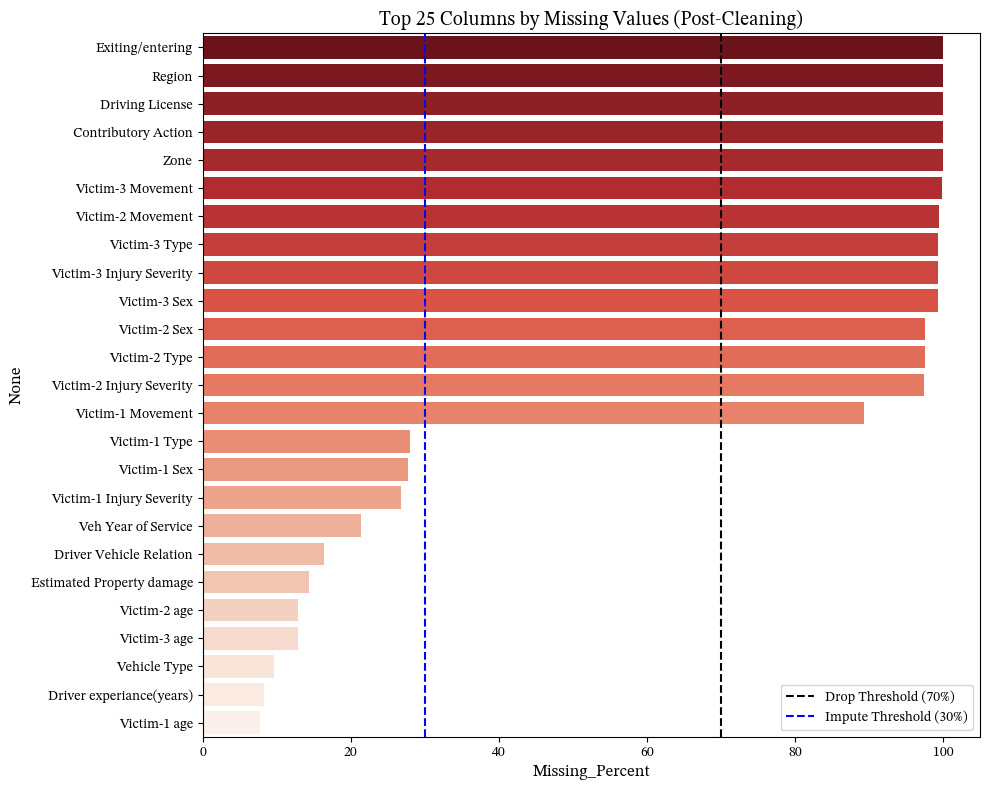

Columns to DROP (>70% Missing):
['Exiting/entering', 'Region', 'Driving License', 'Contributory Action', 'Zone', 'Victim-3 Movement', 'Victim-2 Movement', 'Victim-3 Type', 'Victim-3 Injury Severity', 'Victim-3 Sex', 'Victim-2 Sex', 'Victim-2 Type', 'Victim-2 Injury Severity', 'Victim-1 Movement']

Shape after dropping columns: (60004, 41)


In [8]:
# Calculate Missing Percentage
missing_percent = df_clean.isnull().mean() * 100
missing_df = pd.DataFrame(missing_percent, columns=['Missing_Percent']).sort_values(by='Missing_Percent', ascending=False)

# Visualize Top 20 Missing Columns
plt.figure(figsize=(10, 8))
sns.barplot(
    x='Missing_Percent',
    y=missing_df.index[:25],
    hue=missing_df.index[:25],  # <-- assign y variable to hue
    data=missing_df[:25],
    palette='Reds_r',
    legend=False
)
plt.title("Top 25 Columns by Missing Values (Post-Cleaning)")
plt.axvline(70, color='black', linestyle='--', label='Drop Threshold (70%)')
plt.axvline(30, color='blue', linestyle='--', label='Impute Threshold (30%)')
plt.legend()
plt.tight_layout()
plt.savefig(FIGURES_DIR / "missing_values_cleaned.svg", format='svg')
plt.show()

print("Columns to DROP (>70% Missing):")
cols_to_drop = missing_df[missing_df['Missing_Percent'] > 70].index.tolist()
print(cols_to_drop)

# Drop them for the rest of EDA
df_eda = df_clean.drop(columns=cols_to_drop)
print(f"\nShape after dropping columns: {df_eda.shape}")

<Figure size 1200x600 with 0 Axes>

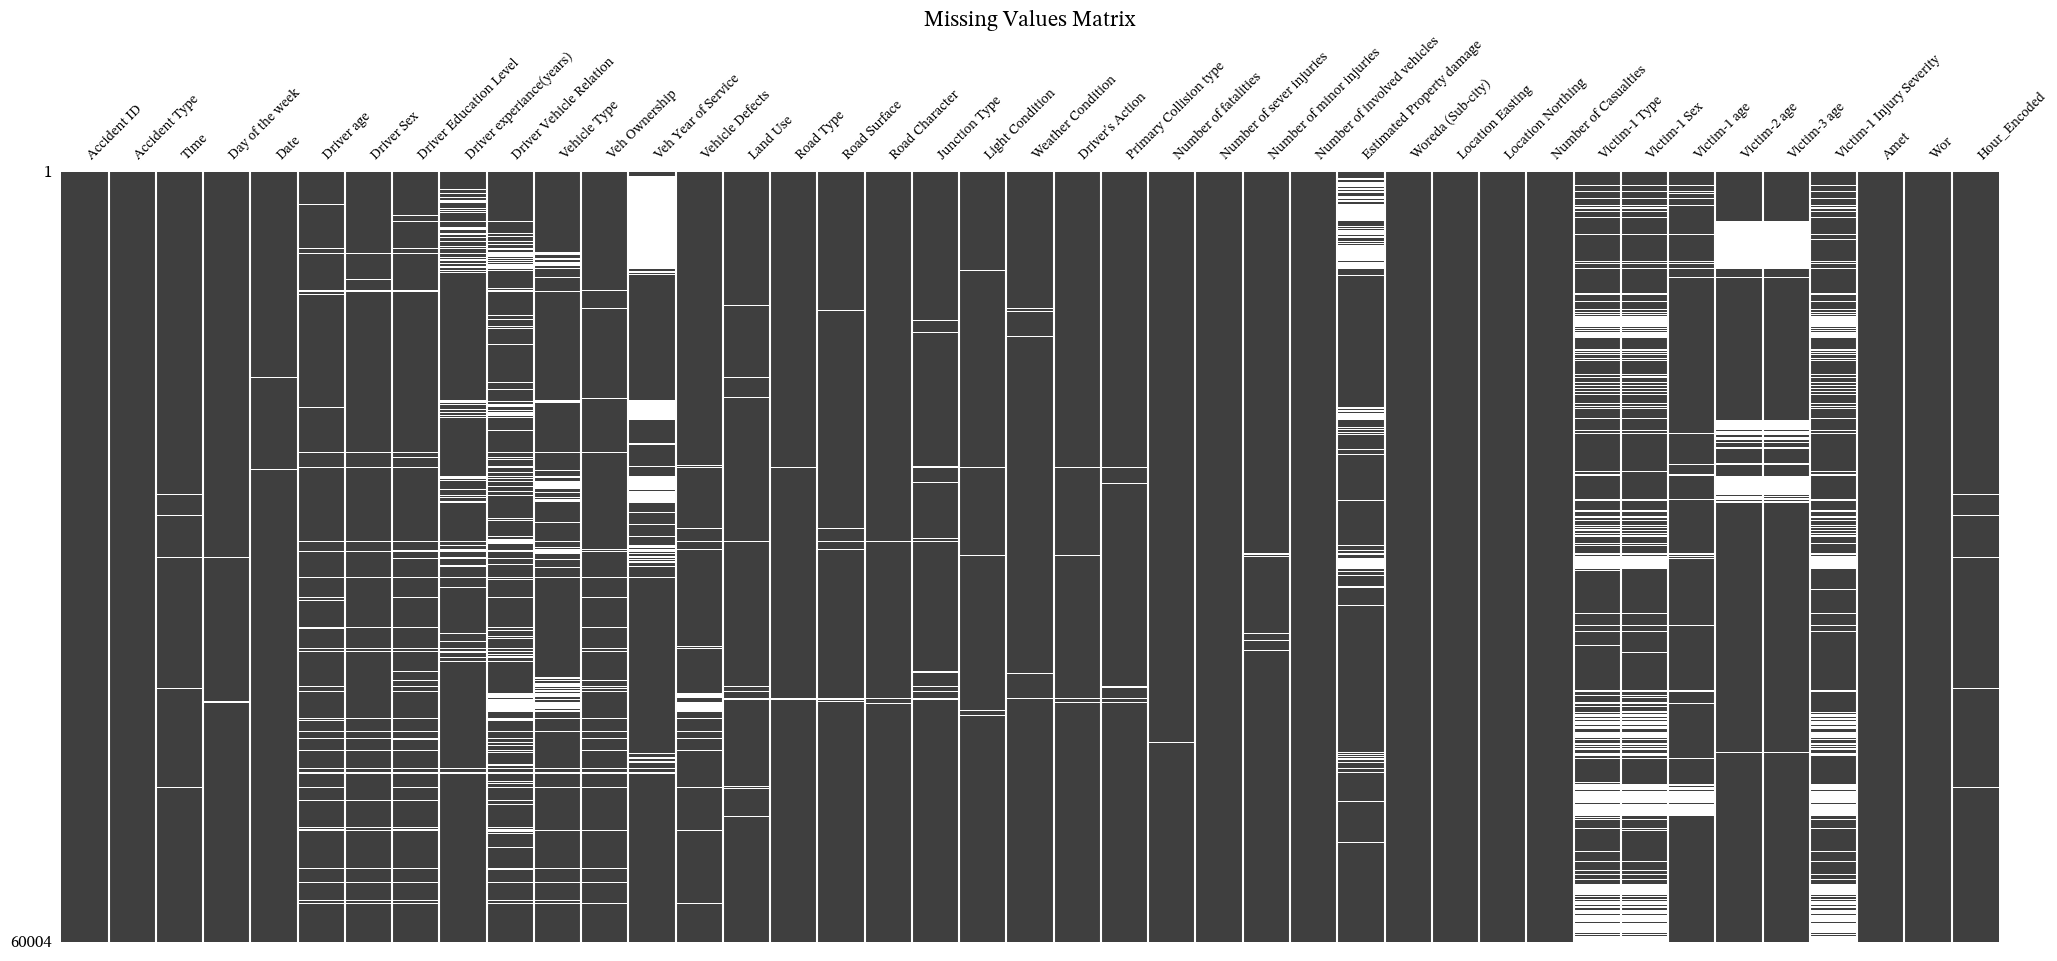

In [9]:
# Visualize Missing Values
plt.figure(figsize=(12, 6))
msno.matrix(df_eda, sparkline=False, fontsize=10)
plt.title("Missing Values Matrix", fontsize=16)
plt.savefig(FIGURES_DIR / "missing_values_matrix.svg", format='svg')
plt.show()

In [10]:
# calculate missing percentage
missing_percent = df_eda.isnull().mean() * 100
missing_df = pd.DataFrame(missing_percent, columns=['Missing_Percent']).sort_values(by='Missing_Percent', ascending=False)
print(missing_df[missing_df['Missing_Percent'] > 0])

                             Missing_Percent
Victim-1 Type                      27.999800
Victim-1 Sex                       27.681488
Victim-1 Injury Severity           26.768215
Veh Year of Service                21.448570
Driver Vehicle Relation            16.333911
Estimated Property damage          14.389041
Victim-2 age                       12.905806
Victim-3 age                       12.827478
Vehicle Type                        9.654356
Driver experiance(years)            8.282781
Victim-1 age                        7.769482
Driver Education Level              4.526365
Driver age                          4.019732
Vehicle Defects                     3.419772
Veh Ownership                       3.078128
Driver Sex                          2.869809
Number of minor injuries            1.319912
Junction Type                       1.158256
Land Use                            0.968269
Road Surface                        0.753283
Primary Collision type              0.594960
Hour_Encod

**Insight on Missing Values:**
- Columns with high missing values (e.g., >50%) such as `Service_Year_of_Vehicle`, `Defect_of_Vehicle`, `Work_of_casuality`, `Fitness_of_casuality` might need to be dropped as they contain too little information.
- Moderate missing values can be handled via imputation (mode for categorical, mean/median for numerical).

## 4. Target Variable Analysis

We chose **`Accident Type`** (Severity) as the target variable.

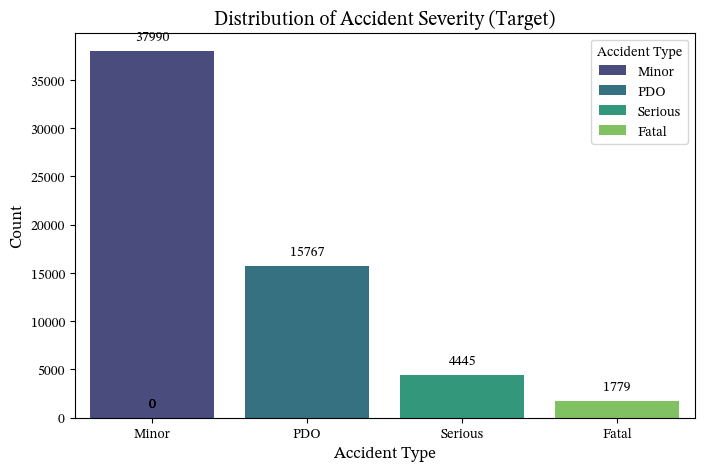

Class Proportions (%):
Accident Type
Minor      63.336723
PDO        26.286657
Serious     7.410680
Fatal       2.965939
Name: proportion, dtype: float64


In [11]:
plt.figure(figsize=(8, 5))
# Calculate percentages
target_counts = df_eda['Accident Type'].value_counts(normalize=True) * 100
ax = sns.countplot(x='Accident Type', data=df_eda, order=target_counts.index, palette='viridis', hue='Accident Type')

# Annotate
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title("Distribution of Accident Severity (Target)")
plt.ylabel("Count")
plt.savefig(FIGURES_DIR / "target_distribution_cleaned.svg", format='svg')
plt.show()

print("Class Proportions (%):")
print(target_counts)

**Insight: Class Imbalance Strategy**
*   The dataset is **highly imbalanced**. `Minor` accidents dominate (\~63%), while `Fatal` accidents are rare (\~3%).
*   **Strategy:** Accuracy will be a misleading metric.
     1.  **Metric:** Use **F1-Score (Macro)** and **Confusion Matrix** for evaluation.
     2.  **Training:** Use `class_weights` in the Loss Function (give higher penalty to Fatal/Serious misclassification).
     3.  **Data Prep:** Optionally use **SMOTE** (Synthetic Minority Over-sampling) on the training set only.

## 5. Feature Distributions & Relationships
*Exploration of feature distributions (histograms, boxplots) and relationships.*

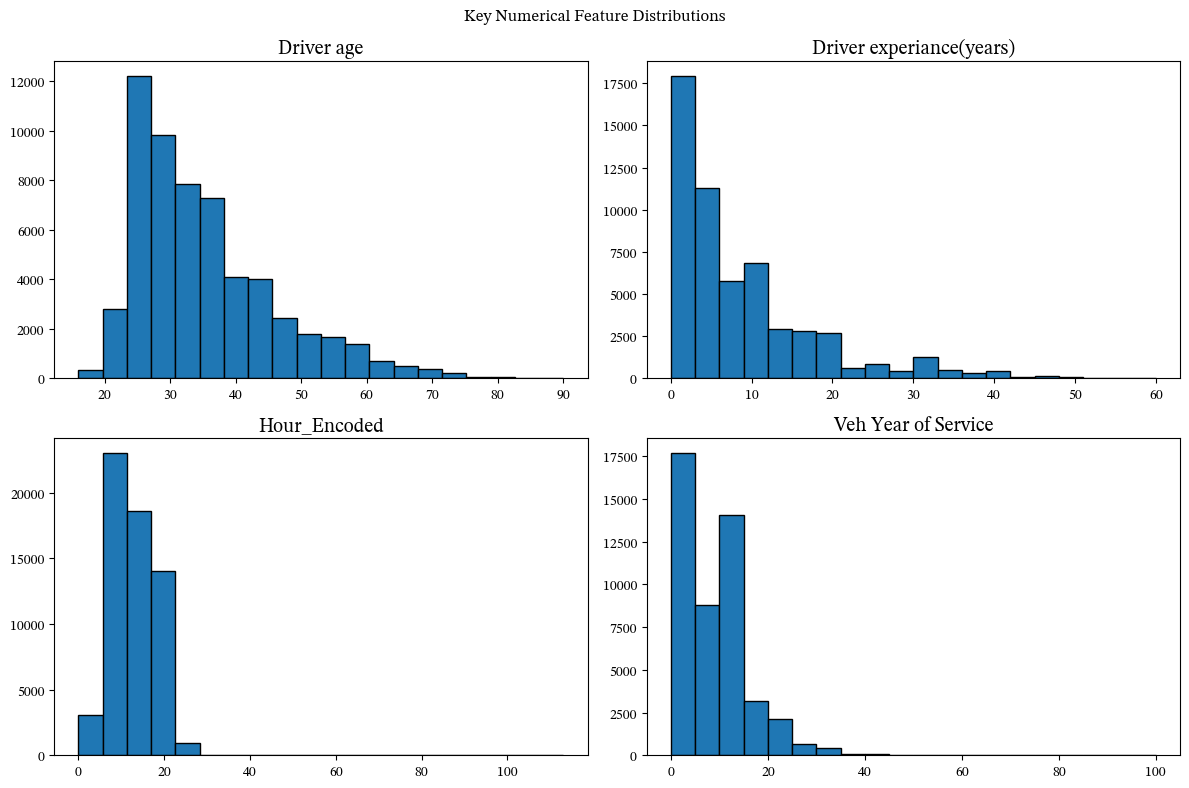

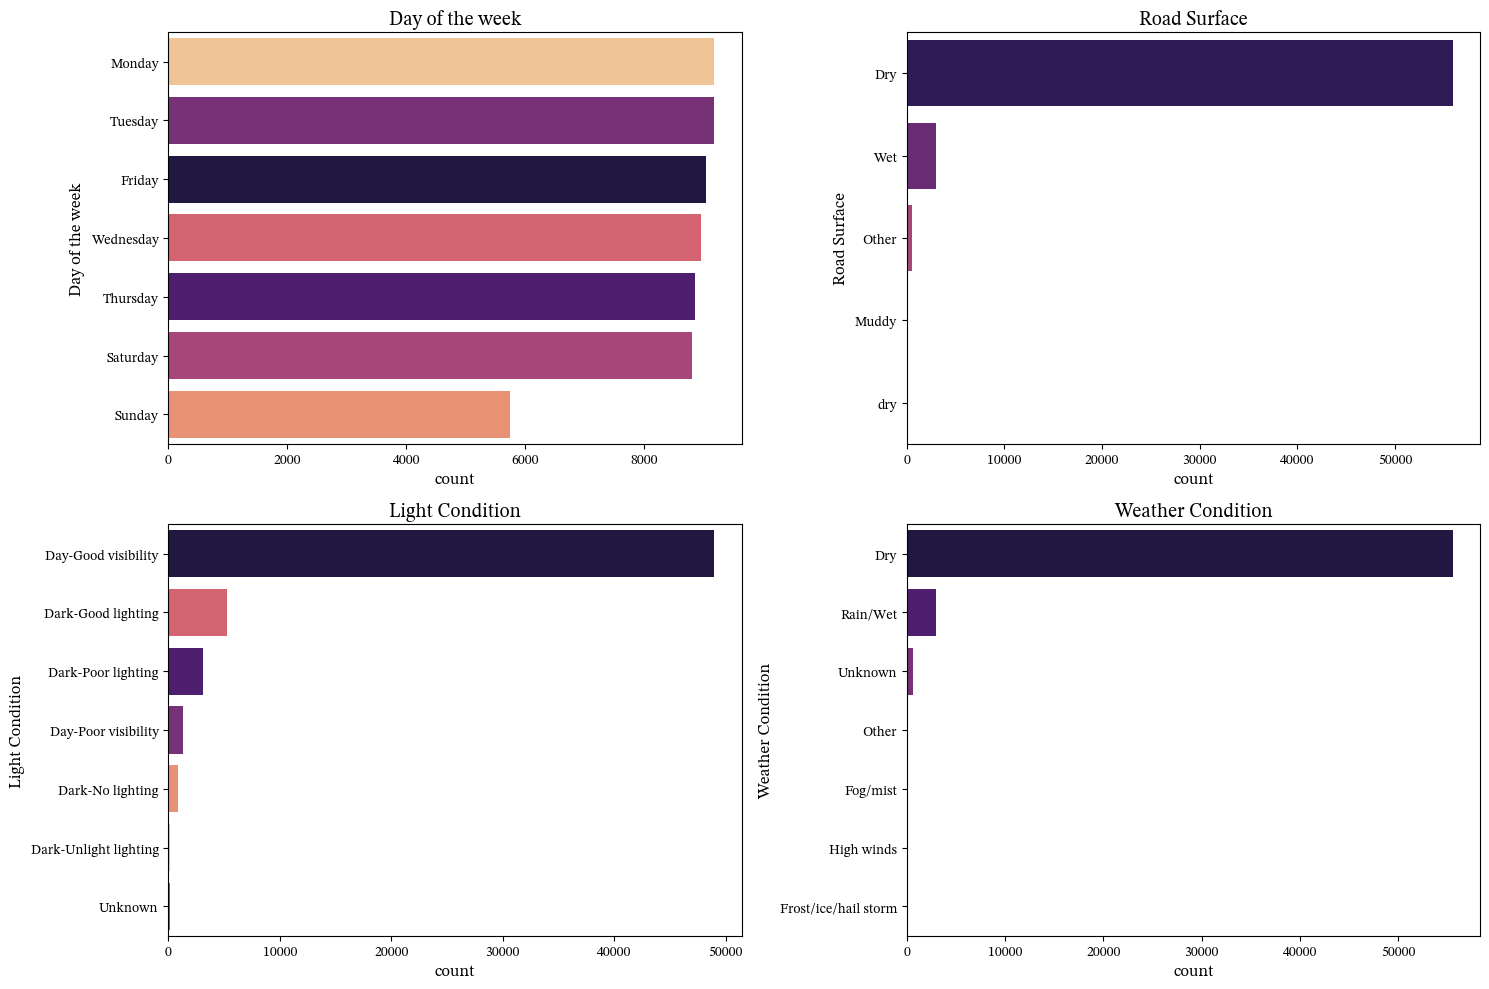

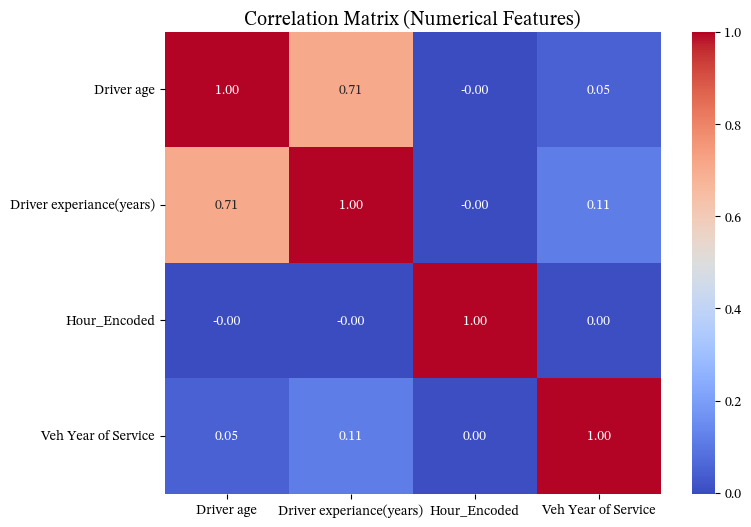

In [12]:
# --- Numerical Distributions ---
num_cols = ['Driver age', 'Driver experiance(years)', 'Hour_Encoded', 'Veh Year of Service']
df_eda[num_cols].hist(figsize=(12, 8), bins=20, edgecolor='black', grid=False)
plt.suptitle("Key Numerical Feature Distributions")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "numerical_hist_cleaned.svg", format='svg')
plt.show()

# --- Categorical Distributions ---
cat_cols = ['Day of the week', 'Road Surface', 'Light Condition', 'Weather Condition']

plt.figure(figsize=(15, 10))
for i, col in enumerate(cat_cols):
    plt.subplot(2, 2, i+1)
    sns.countplot(y=col, data=df_eda, order=df_eda[col].value_counts().index[:10], hue=col, palette='magma', legend=False)
    plt.title(f"{col}")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "categorical_dist_cleaned.svg", format='svg')
plt.show()

# --- Correlation Analysis (Numerical) ---
# Correlation matrix
plt.figure(figsize=(8, 6))
corr = df_eda[num_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix (Numerical Features)")
plt.savefig(FIGURES_DIR / "correlation_matrix.svg", format='svg')
plt.show()


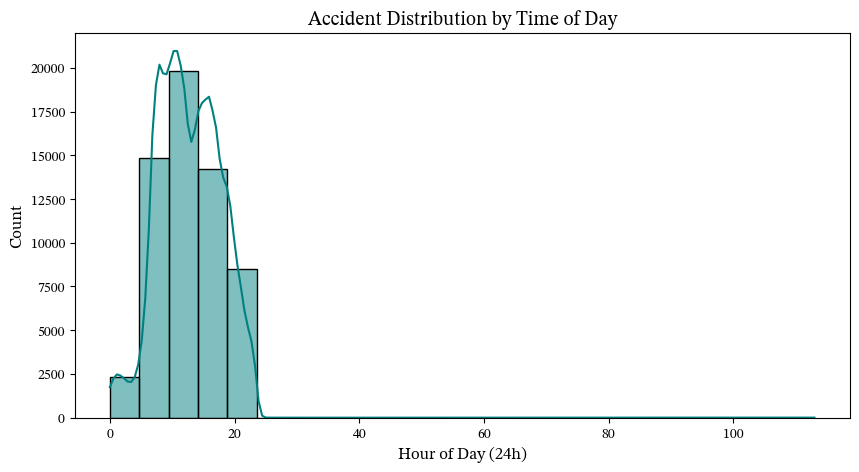

In [13]:
# --- Time Analysis ---
# Extract hour from 'Time' column if format allows (Sample format '15:00-16:00')
df = df_eda.copy()

if 'Time' in df.columns:
    # Extract just the starting hour
    df['Hour'] = df['Time'].astype(str).str.split(':').str[0]
    # Filter out non-numeric values just in case
    df = df[df['Hour'].str.isnumeric()]
    df['Hour'] = df['Hour'].astype(int)
    
    plt.figure(figsize=(10, 5))
    sns.histplot(df['Hour'], bins=24, kde=True, color='teal')
    plt.title("Accident Distribution by Time of Day")
    plt.xlabel("Hour of Day (24h)")
    plt.savefig(FIGURES_DIR / "time_of_day_dist.svg", format='svg')
    plt.show()

## 6. Insights & Next Steps
 
### Data Quality Summary
 *   **Dropped:** Columns with >70% missing data (mostly Victim 2/3 details, Region, Zone) have been identified for removal.
 *   **Imputation Needs:**
     *   `Driver Age`, `Experience`: Impute with **Median** (skewed distributions).
     *   `Categorical Columns` (e.g., Road Surface, Education): Impute with **Mode**.
     *   `Time`: Encoded as Hour (0-23).
 
### Feature Engineering Proposals
 1.  **Time Encoding:** The `Hour` is cyclical (23 is close to 0). For Neural Networks, we should encode this as sin/cos pairs:
     $$ Hour_{sin} = \sin(2 \pi \times \frac{Hour}{24}) $$
     $$ Hour_{cos} = \cos(2 \pi \times \frac{Hour}{24}) $$
 2.  **Categorical Encoding:**
     *   `Day of week`: One-Hot Encoding.
     *   `Road Surface/Light/Weather`: One-Hot Encoding.
 3.  **Scaling:**
     *   Apply `StandardScaler` to Age and Experience.